# About: CoursewareHubの準備

CoursewareHubを構成するサービス - JupyterHubサービスのコンテナと、auth-proxyサービスのコンテナをインストールする。

# Notebookと環境のBinding

Inventory中のgroup名でBind対象ホストを指示する。


- `hosts_file`: Inventoryファイル
- `target_group`: Ansible Inventory中に定義されているグループ( `[グループ名]` のように`[]`で囲まれた定義 )のうち、CoursewareHub構築に使うグループ名を指定します。


In [ ]:
hosts_file = './cwhtest0001_inventory'
target_group = 'cwhtest0001'

# 接続確認
%env ANSIBLE_INVENTORY={hosts_file}
!ansible -m ping {target_group}

作業ディレクトリを作成

In [ ]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

masterとするAnsibleのgroup名を指定する。対象が正しいか、Ansible pingモジュールで動作確認する。

In [ ]:
target_hub = 'cwhub_master'

!ansible -m ping {target_hub} -l {target_group}

workerとするnodeはAnsibleのgroup名で定義する。Ansible pingモジュールで動作確認する。

In [ ]:
target_nodes = 'cwhub_nodes'

!ansible -m ping {target_nodes} -l {target_group}

servicenet_ip変数の確認

In [ ]:
!ansible -m debug -a 'msg={{{{servicenet_ip}}}}' {target_hub}
!ansible -m debug -a 'msg={{{{servicenet_ip}}}}' {target_nodes}

# JupyterHubの準備

In [ ]:
import time
import os.path
import yaml

In [ ]:
default_user = !ansible -a whoami {target_hub}
default_user = default_user[1]
default_user

## restuserのインストール

In [ ]:
!rm -fr {work_dir}/jupyterhub-deploy
!git clone https://github.com/NII-cloud-operation/CoursewareHub-LC_jupyterhub-deploy.git {work_dir}/jupyterhub-deploy

In [ ]:
!cd {work_dir}/jupyterhub-deploy && git log -n 5

In [ ]:
!tree {work_dir}/jupyterhub-deploy/roles/restuser

In [ ]:
with open(os.path.join(work_dir, 'jupyterhub-deploy/install-restuser.yml'), 'w') as f:
    f.write(yaml.dump([{'hosts': target_hub,
                       'become': True,
                       'roles': ['restuser']}]))
!cat {work_dir}/jupyterhub-deploy/install-restuser.yml

In [ ]:
!ansible-playbook -l {target_group} -CDv {work_dir}/jupyterhub-deploy/install-restuser.yml ;:

`epel-release`がdry-runではインストールされないので、`python-pip`のインストールに失敗するのは問題無い。

対象が正しいことを確認して実行する。

In [ ]:
!ansible-playbook -l {target_group} {work_dir}/jupyterhub-deploy/install-restuser.yml

動作テスト

In [ ]:
!ansible -b -m yum -a 'name=nmap-ncat' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m shell -a 'echo -e "POST /{default_user} HTTP/1.0\r\n" | nc -U /var/run/restuser.sock' {target_hub} -l {target_group}

## ネットワークの準備

CoursewareHubの各コンテナの内部通信用のoverlayネットワークを作成する。

コンテナ数の倍のIPアドレスを使用するため、サブネットのサイズは十分な大きさに設定すること。  
singleuserコンテナでも、コンテナごとに2つのIPアドレスを使用する。

In [ ]:
!ansible -b -a 'docker network ls' {target_hub} -l {target_group}
!ansible -b -a 'docker network ls' {target_nodes} -l {target_group}

In [ ]:
!ansible -b -a 'docker network create courseware-backend -d overlay --subnet=10.100.0.0/20' {target_hub} -l {target_group}

In [ ]:
!ansible -b -a 'docker network ls' {target_hub} -l {target_group}
!ansible -b -a 'docker network ls' {target_nodes} -l {target_group}

## PostgreSQLのパラメータ定義

In [ ]:
db_user = 'jhauth'
db_user

In [ ]:
db_name = 'jupyterhub'
db_name

以下は内部的に利用するPostgresのパスワード。自身でパスワードを決め、以下に入力する。

(再構築で既存のDBが存在している場合、前回と同じものを設定すること)

In [ ]:
from getpass import getpass

db_pass = getpass()
len(db_pass)

## PostgreSQLコンテナの準備

PostgreSQLの公式イメージ`postgresq:11`を使用します。


データベースファイルを置くディレクトリを作成

postgresのvolumeはNFS上に置かなければならない

In [ ]:
!ansible -b -m file -a 'path=/jupyter/psql/data state=directory' {target_hub}

DBの初期化用SQLファイル

In [ ]:
import yaml

with open(os.path.join(work_dir, 'create.sql'), 'w') as f:
    f.write('''
CREATE SEQUENCE local_users_id_seq START 1;

CREATE TABLE local_users (
    id  integer CONSTRAINT firstkey PRIMARY KEY,
    user_name  varchar(64) UNIQUE NOT NULL,
    password  varchar(128) NOT NULL,
    mail  varchar(64) NOT NULL
);
''')

!cat {work_dir}/create.sql

In [ ]:
!ansible -b -m file -a 'path=/jupyter/psql state=directory' {target_hub} -l {target_group}
!ansible -b -m copy -a 'src={work_dir}/create.sql dest=/jupyter/psql/create.sql'  {target_hub} -l {target_group}

## ユーザ用イメージの準備

In [ ]:
singleuser_image = 'niicloudoperation/notebook'

In [ ]:
!ansible -b -a 'docker pull {singleuser_image}' {target_hub}
!ansible -b -a 'docker pull {singleuser_image}' {target_nodes}

singleuser用のイメージとして、タグをつけておく

In [ ]:
!ansible -b -a 'docker tag {singleuser_image} niicloudoperation/jupyterhub-singleuser' {target_hub}
!ansible -b -a 'docker tag {singleuser_image} niicloudoperation/jupyterhub-singleuser' {target_nodes}

In [ ]:
!ansible -b -a 'docker images' {target_hub}
!ansible -b -a 'docker images' {target_nodes}

## リソース制限設定

YAMLで設定する。

設定例：

```
groups:
    group1:
        mem_limit: 2G
        cpu_limit 2.0
        mem_gurantee 1G
        cpu_grantee: 0.5
        priority: 1
    group2:
        mem_limit 1G
        cpu_limit: 1.0
        priority: 10
default:
    mem_limit: 1G,
    cpu_limit: 2.0,
    mem_guarantee: 1G
    cpu_guarantee: 0.5
admin:
    mem_limit: 5G
```

In [ ]:
%%writefile {work_dir}/resource.yaml
groups:
    staff:
        mem_limit: 4G
        mem_guarantee: 1G
        cpu_limit: 1.0
        priority: 1
default:
    mem_limit: 1G
    mem_guarantee: 1G
    cpu_limit: 1.0
admin:
    mem_limit: 4G
    mem_guarantee: 1G
    cpu_limit: 1.0


設定ファイルの検証

In [ ]:
!curl -o {work_dir}/resources-schema.json \
    https://raw.githubusercontent.com/NII-cloud-operation/CoursewareHub-LC_platform/master/jupyterhub/resources-schema.json

In [ ]:
import jsonschema
import json
import yaml

with open(os.path.join(work_dir, 'resources-schema.json')) as f:
    resources_config_schema = json.load(f)

with open(os.path.join(work_dir, 'resource.yaml')) as f:
    resources_config = yaml.load(f, Loader=yaml.SafeLoader)
    jsonschema.validate(resources_config, resources_config_schema)

print(json.dumps(resources_config, indent=2))

In [ ]:
!ansible -b -m file -a 'path=/etc/jupyterhub state=directory' {target_hub} -l {target_group}
!ansible -b -m copy -a 'src={work_dir}/resource.yaml dest=/etc/jupyterhub/resource.yaml'  {target_hub} -l {target_group}

## JupyterHubコンテナの準備

JupyterHubはDockerイメージ(`niicloudoperation/coursewarehub-jupyterhub:master`)として提供される。

必要なら、カスタマイズする。

> カスタマイズは、 `/etc/jupyterhub/jupyterhub_config.d/` に `.py` ファイルを設定することで可能。

In [ ]:
!ansible -b -m file -a 'dest=/etc/jupyterhub/jupyterhub_config.d/ state=directory' {target_hub} -l {target_group}

共有ディレクトリ機能を使う場合には、以下のセルのコメントアウトを外す。(専用のNFSボリュームが設定済みの必要がある)

> 本Notebookでは未対応。


In [ ]:
# %%writefile {work_dir}/share_jupyterhub_config.py

# from docker.types import Mount

# extra_user_mounts = []
# extra_user_mounts.append(
#     Mount(
#         type="bind",
#         target='{homedir}/share',
#         source='/share',
#         read_only=False,
#     )
# )
# c.CoursewareUserSpawner.extra_user_mounts = extra_user_mounts



In [ ]:
# !ansible -b -m copy \
#     -a 'src={work_dir}/share_jupyterhub_config.py dest=/etc/jupyterhub/jupyterhub_config.d/share_jupyterhub_config.py' \
#     {target_hub} -l {target_group}

logoのアップロード

> logoをカスタマイズしたい場合は、ログファイルをこのNotebookと同じディレクトリに配置すること。

In [ ]:
!ansible -b -m file -a 'path=/var/jupyterhub/ state=directory' {target_hub} -l {target_group}
!ansible -b -m copy -a 'src=jupyterhub-logo.png dest=/var/jupyterhub/logo.png' {target_hub} -l {target_group}

# auth-proxyの準備

## 環境情報

環境情報をAnsibleの変数から取得する

システム構成のバリエーション

1. フェデレーションに参加するSPとして構成しない (`enable_federation=false`)
  * idp-proxyを使用して、idp-proxy経由でフェデレーションに参加する (`auth_fqdn != ''`)
  * ローカルユーザーのみを使用する (`auth_fqdn == ''`)
2. フェデレーションに参加するSPとして構成する  (`enable_federation=false`)


2.の場合は、運用フェデレーションに参加するSPとして申請し、運用フェデレーションのメタデータに登録済みである必要がある 


CoursewareHubのFQDNをAnsibleに定義した変数から取得する。

In [ ]:
import json

msg_stdout = !ansible -m debug -a 'msg={{{{ master_fqdn }}}}' {target_hub} -l {target_group}
master_fqdn = json.loads(''.join([msg_stdout[0].split()[-1]] + msg_stdout[1:]))['msg']
master_fqdn

In [ ]:
msg_stdout = !ansible -m debug -a 'msg={{{{ auth_fqdn }}}}' {target_hub} -l {target_group}
auth_fqdn = json.loads(''.join([msg_stdout[0].split()[-1]] + msg_stdout[1:]))['msg']
auth_fqdn

In [ ]:
msg_stdout = !ansible -m debug -a 'msg={{{{ enable_federation }}}}' {target_hub} -l {target_group}
enable_federation = json.loads(''.join([msg_stdout[0].split()[-1]] + msg_stdout[1:]))['msg']
enable_federation

## フェデレーションに直接参加するSPの場合の追加作業

idp-proxyを利用せずに、直接フェデレーションに参加する場合に必要な証明書、メタデータなどを用意する。

> `enable_federation=true`の場合に必要


フェデレーションメタデータ検証用証明書の用意

In [ ]:
#ds_metadata_signer_url = 'https://metadata.gakunin.nii.ac.jp/gakunin-test-signer-2011.cer'
#ds_metadata_signer_url

In [ ]:
#ds_metadata_signer = 'gakunin-signer.cer'
#ds_metadata_signer

In [ ]:
#!curl -L -o {work_dir}/{ds_metadata_signer} '{ds_metadata_signer_url}'
#!ls -l {work_dir}/{ds_metadata_signer}

In [ ]:
#!ansible -b -m file -a 'path=/etc/jupyterhub/simplesamlphp/cert state=directory' {target_hub}
#!ansible -b -m copy -a 'src={work_dir}/{ds_metadata_signer} dest=/etc/jupyterhub/simplesamlphp/cert/' {target_hub}

**テスト用クラウドゲートウェイを利用するときのみ**

クラウドゲートウェイメタデータの用意

学認から別途入手し、ローカルに配置済みとする。

In [ ]:
## cgidp_metadata = 'sptestcgidp-metadata-self-signed-cert.xml.20200129'
## cgidp_metadata = 'sptestcgidp-metadata-self-signed-cert.xml'
#cgidp_metadata = 'sptestcgidp-metadata-self-signed-cert.xml.20200305'
#cgidp_metadata

In [ ]:
#!ls -l {cgidp_metadata}

In [ ]:
#!ansible -b -m file -a 'path=/etc/jupyterhub/simplesamlphp/metadata/xml state=directory' {target_hub}
#!ansible -b -m copy -a 'src={cgidp_metadata} dest=/etc/jupyterhub/simplesamlphp/metadata/xml/cgidp-metadata.xml' {target_hub}

## LTI認証連携設定

> LTIを設定しない場合も実行すること。

In [ ]:
lti_key_dir = '/etc/jupyterhub/lti'
lti_key_dir

In [ ]:
lti_key_file = os.path.join(lti_key_dir, 'private.key')
lti_key_file

In [ ]:
!ansible -b -m file -a 'path={lti_key_dir} state=directory'  {target_hub} -l {target_group}

必要ならキーペアを生成

In [ ]:
!ansible -b -m shell -a 'openssl genrsa -out {lti_key_file} creates={lti_key_file}' {target_hub} -l {target_group}

公開鍵を確認する。

この公開鍵は、将来のLMS連携機能のために使用する。認証連携には使用しない。

In [ ]:
lti_pubkey = !ansible -b -m shell -a 'openssl rsa -pubout -in {lti_key_file} 2>/dev/null' {target_hub}
assert '-----BEGIN PUBLIC KEY-----' in lti_pubkey
lti_pubkey = lti_pubkey[lti_pubkey.index('-----BEGIN PUBLIC KEY-----'):lti_pubkey.index('-----END PUBLIC KEY-----')+1]
print('\n'.join(lti_pubkey))

このCoursewareHubを、LMS上でExternal Toolとして使用する時に必要になるパラメータ。

**LMSへExternal Toolとして登録する時、E-Mailアドレスをツールに送信するように設定すること。**

In [ ]:
print('Tool URL / Launch URL:\n\t https://{}/'.format(master_fqdn))
print('Initiate login URL / LTI 1.3 Tool OpenID Connect/Initialization Endpoint:\n\t https://{}/php/lti/login.php'.format(master_fqdn))
print('Redirection URI / LTI 1.3 Tool Redirect Endpoint:\n\t https://{}/php/lti/service.php'.format(master_fqdn))

連携設定用関数

In [ ]:
def moodle_lti_config(lti_config, url, client_id, deployment='1'):
    lti_config[url] = {
        'client_id': client_id,
        'auth_login_url': '{}/mod/lti/auth.php'.format(url),
        'auth_token_url': '{}/mod/lti/token.php'.format(url),
        'key_set_url': '{}/mod/lti/certs.php'.format(url),
        'private_key_file': '/private.key',
        'deployment': [
            deployment
        ]
    }
    return lti_config

def sakai_lti_config(lti_config, issuer_url, client_id, id):
    lti_config[issuer_url] = {
        'client_id': client_id,
        'auth_login_url': '{}/imsoidc/lti13/oidc_auth'.format(issuer_url),
        'auth_token_url': '{}/imsblis/lti13/token/{}'.format(issuer_url, id),
        'key_set_url': '{}/imsblis/lti13/keyset/{}'.format(issuer_url, id),
        'private_key_file': '/private.key',
        'deployment': [
            '1'
        ]
    }
    return lti_config

設定方法

**Moodleの場合**

* Dashboard / Site administration / Plugins / Activity modules / External tool / Manage tools を開く
* このCoursewareHubに対応するツールの、View configuration details ボタンをクリックし、接続情報を確認する （ツールが存在していなければ作成する） 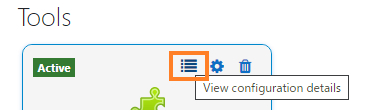 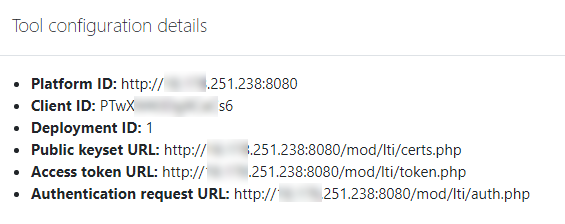


確認した、PlatformID, Client IDを引数にして、以下のように呼び出す。

```
moodle_lti_config(lti_config, Platform ID, Client ID)
```

**Sakaiの場合**

* adminでログイン
* Administration Workspace → External Tools
* Installed Toolsタブで、このCoursewareHubに対応するツールの情報を確認する
 * 存在していなければ作成する
* 以下の項目を確認 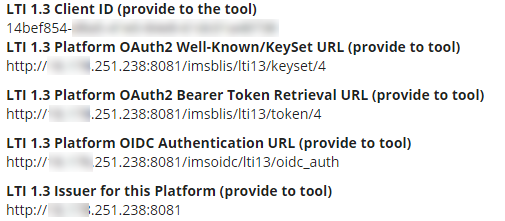
* OAuth2 Well-Known/KeySet URL と、OAuth2 Bearer Token Retrieval URL の最後の数字をIDとする

確認した、Issuer, Client ID、IDを引数にして、以下のように呼び出す。
```
sakai_lti_config(lti_config, LTI 1.3 Issuer, Client ID, ID)
```

連携設定

In [ ]:
lti_config = {}

# LTI設定しない場合はコメントアウトでOK
#moodle_lti_config(lti_config, 'http://xxx.xxx.xxx.xxx:8080', 'PTwXM43D???????')
#sakai_lti_config(lti_config, 'http://xxx.xxx.xxx.xxx:8081', '14bef854-d8a5-41e0-84e8-????????????', 4)

lti_config

In [ ]:
import json

with open(os.path.join(work_dir, 'lti.json'), 'w') as f:
    f.write(json.dumps(lti_config, indent=2))
    
!cat {work_dir}/lti.json

In [ ]:
!ansible -b -m file -a 'path=/etc/jupyterhub state=directory' {target_hub} -l {target_group}
!ansible -b -m copy -a 'src={work_dir}/lti.json dest=/etc/jupyterhub/lti/lti.json'  {target_hub} -l {target_group}

## 証明書の配置

証明書をマスターノード上に配置する。

In [ ]:
import os

In [ ]:
certreq_path = '/home/' + default_user + '/certs'

In [ ]:
!ansible -m file -a 'path={certreq_path} state=directory owner={default_user}' {target_hub} -l {target_group}

ターミナルからマスターノードにSSHでログインして、以下の場所に証明書と秘密鍵を配置する。 (出どころなどを必要以上に残さないため)

証明書は有効なものである必要があります。自己証明証明書などの場合、仮にブラウザでアクセスを許可したとしても、接続できません。

In [ ]:
print('Certificate:')
print(os.path.join(certreq_path, master_fqdn + ".key"))
print('Private Key:')
print(os.path.join(certreq_path, master_fqdn + ".cer"))

中間証明書が必要な場合は、中間証明書のファイル名を以下に設定します。

In [ ]:
intermediate_certfile = "nii-odca4g7rsa.cer"

In [ ]:
if intermediate_certfile:
    print(os.path.join(certreq_path, intermediate_certfile))

In [ ]:
# 証明書を配置したら、Freezeして次へ
assert False

keyはPassphraseなしで使用可能になっていること。

In [ ]:
!ansible -a 'ls -la {os.path.join(certreq_path, master_fqdn + ".key")}' {target_hub} -l {target_group}
!ansible -a 'ls -la {os.path.join(certreq_path, master_fqdn + ".cer")}' {target_hub} -l {target_group}
if intermediate_certfile:
    !ansible -a 'ls -la {os.path.join(certreq_path, intermediate_certfile)}' {target_hub} -l {target_group}

証明書と秘密鍵を確認する。

証明書の内容と、両者に含まれる公開鍵のfingerprintを確認する。

> 実行が完了しない場合は、パスフレーズが設定されている可能性がある

In [ ]:
!ansible -m shell -a 'openssl rsa -in {os.path.join(certreq_path, master_fqdn + ".key")} -pubout | openssl sha1 -c' {target_hub} -l {target_group}

In [ ]:
!ansible -m shell -a 'openssl x509 -noout -in {os.path.join(certreq_path, master_fqdn + ".cer")} -pubkey | openssl sha1 -c' {target_hub} -l {target_group}
!ansible -a 'openssl x509 -text -noout -in {os.path.join(certreq_path, master_fqdn + ".cer")}' {target_hub} -l {target_group}

idp-proxyを利用しない場合は、idp-proxyの証明書は不要

In [ ]:
if not enable_federation and auth_fqdn != '':
    !ansible -a 'ls -la {os.path.join(certreq_path, auth_fqdn + ".cer")}' {target_hub} -l {target_group}

## auth-proxyコンテナの準備

メタデータ用ディレクトリを作成　(フェデレーションに直接参加する場合は、ここにクラウドゲートウェイのメタデータを置くことがある)

In [ ]:
!ansible -b -m file -a 'path=/etc/jupyterhub/simplesamlphp/metadata/xml state=directory' {target_hub}

設定ファイルを生成

In [ ]:
with open(os.path.join(work_dir, 'hub-const.php'), 'w') as f:
    f.write('''<?php
const COURSE_NAME = "";
const HUB_URL = "http://{master_ip}:8000";
const AUTHOR_GROUP_LIST = array ({{{{ cg_groups | map('regex_replace', '(^|$)', "'") | join('\", \"') }}}});
const DB_USER = "{db_user}";
const DB_PASS = "{db_pass}";
const DB_PORT = "5432";
const DB_NAME = "{db_name}";
const DB_HOST = "postgres";
?>'''.format(master_ip='jupyterhub', db_user=db_user, db_pass=db_pass, db_name=db_name))

設定ファイルを転送

In [ ]:
!ansible -b -m template -a 'src={work_dir}/hub-const.php dest=/etc/jupyterhub/hub-const.php'  {target_hub} -l {target_group}

証明書、秘密鍵等を全ノードにデプロイする


In [ ]:
!ansible -b -m file -a 'path=/etc/jupyterhub/nginx/certs state=directory' {target_hub} -l {target_group}
!ansible -b -a 'cp {os.path.join(certreq_path, master_fqdn + ".key")} /etc/jupyterhub/nginx/certs/auth-proxy.key' {target_hub} -l {target_group}
if intermediate_certfile:
    !ansible -b -m shell -a 'cat {os.path.join(certreq_path, master_fqdn + ".cer")} \
      {os.path.join(certreq_path, intermediate_certfile)} \
      > /etc/jupyterhub/nginx/certs/auth-proxy.chained.cer' {target_hub} -l {target_group}
else:
    !ansible -b -m shell -a 'cat {os.path.join(certreq_path, master_fqdn + ".cer")} \
      > /etc/jupyterhub/nginx/certs/auth-proxy.chained.cer' {target_hub}
!ansible -b -m file -a 'path=/etc/jupyterhub/simplesamlphp/cert state=directory' {target_hub} -l {target_group}
!ansible -b -a 'cp {os.path.join(certreq_path, master_fqdn + ".key")} /etc/jupyterhub/simplesamlphp/cert/auth-proxy.key' {target_hub} -l {target_group}
if not enable_federation and auth_fqdn != '':
    !ansible -b -a 'cp {os.path.join(certreq_path, auth_fqdn + ".cer")} /etc/jupyterhub/simplesamlphp/cert/idp-proxy.cer' {target_hub} -l {target_group}
!ansible -b -m shell -a 'cp {os.path.join(certreq_path, master_fqdn + ".cer")} \
    /etc/jupyterhub/simplesamlphp/cert/auth-proxy.cer' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m shell -a 'chdir=/etc/jupyterhub/ rm -f /exchange/config-jupyterhub.tar.gz && \
         tar czvf /exchange/config-jupyterhub.tar.gz .' {target_hub} -l {target_group}
!ansible -b -m file -a 'path=/etc/jupyterhub state=absent' {target_nodes} -l {target_group}
!ansible -b -m file -a 'path=/etc/jupyterhub state=directory' {target_nodes} -l {target_group}
!ansible -b -m shell -a 'chdir=/etc/jupyterhub/ tar zxvf /exchange/config-jupyterhub.tar.gz' {target_nodes} -l {target_group}
!ansible -b -m file -a 'path=/exchange/config-jupyterhub.tar.gz state=absent' {target_hub} -l {target_group}

SimpleSAMLphp cronモジュールのトリガー用secret文字列を生成

In [ ]:
import random
import string
cron_secret = ''.join([random.choice("abcdef" + string.digits) for _ in range(32)])
cron_secret

# サービスの起動

サービスはdocker-compose.ymlで定義し、docker stackコマンドで起動します。

配備先のディレクトリを準備

In [ ]:
!ansible -b -m file -a 'dest=/opt/coursewarehub state=directory' {target_hub} -l {target_group}

## docker-compose.ymlの生成

> *MEMO auth-proxy内でFQDNでProxyをしたくなる箇所があるようなので、container中からhost NICに迂回しないようhost mappingを追加*

あらかじめ定義されたAnsibleの変数から生成します。

まず、テンプレートを用意します。

In [ ]:
import os

docker_compose_j2_path = os.path.join(work_dir, 'docker-compose.yml.j2')

with open(docker_compose_j2_path, 'w') as f:
    f.write('''
version: '3.8'    
services:
  auth-proxy:
    deploy:
      placement:
        constraints:
        - node.role==manager
      replicas: 1
    depends_on:
      - jupyterhub
    healthcheck:
      test: ["CMD", "curl", "-k", "-f", "https://localhost/php/login.php"]
      interval: 30s
      timeout: 3s
      retries: 3
      start_period: 5s
    environment:
      AUTH_FQDN: "{{ auth_fqdn }}"
      CRON_SECRET: "{{ cron_secret }}"
      HUB_NAME: jupyterhub
      MASTER_FQDN: "{{ master_fqdn }}"
    extra_hosts:
    - {{ master_fqdn }}:127.0.0.2
    hostname: auth-proxy
    image: "{{ auth_proxy_image }}"
    networks:
    - backend
    ports:
    - 80:80
    - 443:443
    volumes:
    - read_only: true
      source: /etc/jupyterhub/nginx/certs
      target: /etc/nginx/certs
      type: bind
    - read_only: true
      source: /etc/jupyterhub/hub-const.php
      target: /var/www/lib/hub-const.php
      type: bind
    - read_only: true
      source: /etc/jupyterhub/lti/private.key
      target: /var/www/lib/lti/private.key
      type: bind
    - read_only: true
      source: /etc/jupyterhub/lti/lti.json
      target: /var/www/lib/lti/configs/lti.json
      type: bind
    - read_only: true
      source: /etc/jupyterhub/simplesamlphp/metadata/xml
      target: /var/www/simplesamlphp/metadata/xml
      type: bind
    - read_only: true
      source: /etc/jupyterhub/simplesamlphp/cert
      target: /var/www/simplesamlphp/cert
      type: bind
  jupyterhub:
    deploy:
      placement:
        constraints:
        - node.role==manager
      replicas: 1
    depends_on:
      - postgres
    environment:
      BACKEND_NETWORK: courseware-backend
      CONCURRENT_SPAWN_LIMIT: "{{ concurrent_spawn_limit | default('20')}}"
      CONTAINER_IMAGE: niicloudoperation/jupyterhub-singleuser
{% if cull_server is defined %}
      CULL_SERVER: '{{ cull_server }}'
{% endif %}
{% if cull_server_every is defined %}
      CULL_SERVER_EVERY: '{{ cull_server_every }}'
{% endif %}
{% if cull_server_idle_timeout is defined %}
      CULL_SERVER_IDLE_TIMEOUT: '{{ cull_server_idle_timeout }}'
{% endif %}
{% if cull_server_max_age is defined %}
      CULL_SERVER_MAX_AGE: '{{ cull_server_max_age }}'
{% endif %}
      DEBUG: 'yes'
      POSTGRES_ENV_JPY_PSQL_PASSWORD: "{{ db_pass }}"
      POSTGRES_ENV_JPY_PSQL_USER: {{ db_user }}
      POSTGRES_PORT_5432_TCP_ADDR: 'postgres'
      RESOURCE_ALLOCATION_FILE: /srv/jupyterhub/resource.yaml
      SPAWNER_CONSTRAINTS: node.role==worker
      SPAWNER_HTTP_TIMEOUT: "{{ spawner_http_timeout | default('120') }}"
      SPAWNER_RESTART_MAX_ATTEMPTS: "{{ spawner_restart_max_attempts | default('5') }}"
      SPAWNER_START_TIMEOUT: "{{ spawner_start_timeout | default('60') }}"
{% if jupyterhub_singleuser_app is defined %}
      JUPYTERHUB_SINGLEUSER_APP: '{{ jupyterhub_singleuser_app }}'
{% endif %}
    hostname: jupyterhub
    image: {{ jupyterhub_image }}
    networks:
    - backend
    ports:
    - 8000:8000
    - 8081:8081
    volumes:
    - source: /var/run/docker.sock
      target: /var/run/docker.sock
      type: bind
    - source: /var/run/restuser.sock
      target: /var/run/restuser.sock
      type: bind
    - read_only: true
      source: /var/jupyterhub/logo.png
      target: /var/jupyterhub/logo.png
      type: bind
    - read_only: true
      source: /etc/jupyterhub/resource.yaml
      target: /srv/jupyterhub/resource.yaml
      type: bind
    - read_only: true
      source: /etc/jupyterhub/jupyterhub_config.d
      target: /jupyterhub_config.d
      type: bind
  postgres:
    deploy:
      placement:
        constraints:
        - node.role==manager
      replicas: 1
    environment:
      PGDATA: /var/lib/postgresql/data/pgdata
      POSTGRES_DB: jupyterhub
      POSTGRES_PASSWORD: "{{ db_pass }}"
      POSTGRES_USER: {{ db_user }}
    hostname: postgres
    image: postgres:11
    networks:
    - backend
    volumes:
    - source: /jupyter/psql/data
      target: /var/lib/postgresql/data
      type: bind
    - source: /jupyter/psql/create.sql
      target: /docker-entrypoint-initdb.d/create.sql
      type: bind
networks:
  backend:
    external: true
    name: courseware-backend
'''.lstrip())

In [ ]:
!cat {docker_compose_j2_path}

テンプレートの展開、マスターノードへの配備を行います。

In [ ]:
!ansible -CDv -b --extra-vars "db_user={db_user} db_pass={db_pass} cron_secret={cron_secret}" -m template \
    -a 'src={docker_compose_j2_path} dest=/opt/coursewarehub/docker-compose.yml' {target_hub} -l {target_group}

In [ ]:
!ansible -b --extra-vars "db_user={db_user} db_pass={db_pass} cron_secret={cron_secret}" -m template \
    -a 'src={docker_compose_j2_path} dest=/opt/coursewarehub/docker-compose.yml' {target_hub} -l {target_group}

## 起動

配備したdocker-compose.ymlを使用して、サービスを起動します。

In [ ]:
!ansible -b -a 'docker pull {{{{ auth_proxy_image }}}}' {target_hub} -l {target_group}

In [ ]:
!ansible -b -a 'docker pull {{{{ jupyterhub_image }}}}' {target_hub} -l {target_group}

In [ ]:
!ansible -b -a 'chdir=/opt/coursewarehub docker stack deploy -c docker-compose.yml coursewarehub' {target_hub} -l {target_group}

サービス起動完了のタイミングが揃わないので、すぐには安定しません。

コンテナが何度か再起動されて、安定するまで待ちます。

In [ ]:
time.sleep(60)

１分以上かかる場合もあるので、何度か確認してください。

すべての `REPLICAS`が、`1/1`になっていることを確認すること。

In [ ]:
!ansible -b -a 'docker service ls' {target_hub}

ログをチェック

ログの順番は、タイムスタンプの順序通りでない場合があります。

In [ ]:
!ansible -b -a 'docker service logs coursewarehub_auth-proxy' {target_hub}

In [ ]:
!ansible -b -a 'docker service logs coursewarehub_jupyterhub' {target_hub}

## 確認

メタデータファイルの存在と、ログの確認

ローカルユーザーのみ使用する場合、メタデータは存在しなくてもかまわない

コンテナが動作するノードを調べて、コンテナ内部のファイルを確認する。

In [ ]:
%%writefile {work_dir}/get_servicenet_ip.yml
---
- become: true
  hosts: all
  tasks:
      - debug: "msg={{inventory_hostname}}={{servicenet_ip}}"


In [ ]:
import re

servicenet_result = {}

msgout = !ansible-playbook -l {target_group} {work_dir}/get_servicenet_ip.yml
msgout = msgout.grep('"msg"')
assert len(msgout) >= 1
for l in msgout:
    m = re.match(r'.*\"msg\": \"(.+)=(.+)\"', l)
    if m:
        servicenet_result[m.group(2)] = m.group(1)
servicenet_result

In [ ]:
auth_proxy_id = !ansible -b -a 'docker service ps coursewarehub_auth-proxy -q' {target_hub} -l {target_group}
auth_proxy_id = auth_proxy_id[1]
auth_proxy_id = auth_proxy_id.strip()
auth_proxy_id

In [ ]:
output = !ansible -b -a 'docker inspect --format "{{% raw %}} {{{{.NodeID}}}} {{{{.Status.ContainerStatus.ContainerID}}}}" {{% endraw %}} {auth_proxy_id}' {target_hub} -l {target_group}
auth_proxy_node_id, auth_proxy_container_id = output[1].split()
(auth_proxy_node_id, auth_proxy_container_id)

In [ ]:
output = !ansible -b -a 'docker node inspect --format "{{% raw %}} {{{{.Status.Addr}}}}" {{% endraw %}} {auth_proxy_node_id}' {target_hub} -l {target_group}
auth_proxy_node_ip = output[1].split()
auth_proxy_node_ip = [servicenet_result[x] for x in auth_proxy_node_ip]
auth_proxy_node_ip

In [ ]:
!ansible -b -a 'docker exec -i {auth_proxy_container_id} find /var/www/simplesamlphp/metadata/' \
    {auth_proxy_node_ip[0]}

In [ ]:
!ansible -b -a 'docker exec -i {auth_proxy_container_id} cat /var/www/simplesamlphp/log/simplesamlphp.log' \
    {auth_proxy_node_ip[0]}

idp-proxyを利用する場合は、そのメタデータが必要

idp-proxyを使用しない場合は、空で問題無い。

In [ ]:
!ansible -b -a 'docker exec -i {auth_proxy_container_id} ls -l /var/www/simplesamlphp/metadata/idp-proxy' \
    {auth_proxy_node_ip[0]}

フェデレーションに直接参加するSPの場合、フェデレーションメタデータが必要。それ以外ではエラーでも問題ない。

In [ ]:
!ansible -b -a 'docker exec -i {auth_proxy_container_id} ls -l /var/www/simplesamlphp/metadata/gakunin-metadata' \
    {auth_proxy_node_ip[0]} ;:

必要なメタデータが無い場合は、手動でメタデータを更新する。以下のページにアクセスする。

In [ ]:
!echo "https://{master_fqdn}/simplesaml/module.php/cron/cron.php?key={cron_secret}&tag=daily&output=xhtml"

再確認

In [ ]:
!ansible -b -a 'docker exec -i {auth_proxy_container_id} ls -l /var/www/simplesamlphp/metadata/idp-proxy' \
    {auth_proxy_node_ip[0]}

In [ ]:
!ansible -b -a 'docker exec -i {auth_proxy_container_id} ls -l /var/www/simplesamlphp/metadata/gakunin-metadata' \
    {auth_proxy_node_ip[0]} ;:

# 管理者の追加

最初のユーザーとして、管理者のユーザーを作成する。

## 管理者情報の設定

管理者のメールアドレスを指定する。

In [ ]:
teacher_email = 'cwhadmin@example.com'
teacher_email

In [ ]:
# 適当なアドレスを指定したことを確認したら、このセルをFreezeして先に進めます。
assert False

In [ ]:
import hashlib
import re

def get_username_from_mail_address(mail_address):
    # Convert to lower and remove characters except alphabetic
    wk = mail_address.split('@')
    local_part = wk[0].lower()
    result = re.sub(r'[^a-zA-Z0-9]', '', local_part)
    # Add top 6bytes of hash string
    md5 = hashlib.md5()
    md5.update(mail_address.encode('us-ascii'))
    h = md5.hexdigest()[0:6]
    result += 'x'
    result += h;
    return result;

In [ ]:
teacher_id = get_username_from_mail_address(teacher_email)
teacher_id

In [ ]:
! ! ansible -a 'id {teacher_id}' {target_hub} -l {target_group}

## Systemユーザの作成

In [ ]:
!ansible -b -m file -a 'path=/jupyter/users state=directory' {target_hub} -l {target_group}

In [ ]:
local_user_info = !ansible -b -m user -a 'name={teacher_id} home=/jupyter/users/{teacher_id}' {target_hub} -l {target_group}
local_user_info

In [ ]:
import json
teacher_uid = json.loads(''.join([local_user_info[0].split()[-1]] + local_user_info[1:]))['uid']
teacher_uid

In [ ]:
!ansible -b -a 'ls -la /jupyter/users/{teacher_id}' {target_hub} -l {target_group}

In [ ]:
!ansible -a 'id {teacher_uid}' {target_hub} -l {target_group}

他のノードにもユーザーを作成する。

ユーザのUID/GIDを変数にセットする。


In [ ]:
import re

teacher_info = !ansible -a 'id {teacher_id}' {target_hub} -l {target_group}
teacher_info = re.match(r'uid=(\d+)\((\S+)\)\s+gid=(\d+)\((\S+)\)', teacher_info[1])
teacher_uid = teacher_info.group(1)
assert teacher_id == teacher_info.group(2)
teacher_gid = teacher_info.group(3)
teacher_group = teacher_info.group(4)
(teacher_uid, teacher_gid, teacher_group)

グループを作成

In [ ]:
!ansible -CDv -b -m group -a 'name={teacher_group} gid={teacher_gid}' {target_nodes} -l {target_group}

In [ ]:
!ansible -b -m group -a 'name={teacher_group} gid={teacher_gid}' {target_nodes} -l {target_group}

ユーザー作成

In [ ]:
!ansible -CDv -b -m user \
    -a 'name={teacher_id} uid={teacher_uid} group={teacher_group} home=/jupyter/users/{teacher_id}' {target_nodes} -l {target_group}

In [ ]:
!ansible -b -m user \
    -a 'name={teacher_id} uid={teacher_uid} group={teacher_group} home=/jupyter/users/{teacher_id}' {target_nodes} -l {target_group}

In [ ]:
!ansible -a 'id {teacher_id}' {target_nodes} -l {target_group}

## Prepare contents directory

`info`, `textbook` ディレクトリを準備する。

In [ ]:
!ansible -b -CD -m file -a 'path=/jupyter/users/{teacher_id}/info owner={teacher_uid} group={teacher_group} mode=0777 state=directory' {target_hub} -l {target_group}
!ansible -b -CD -m file -a 'path=/jupyter/users/{teacher_id}/textbook owner={teacher_uid} group={teacher_group} mode=0777 state=directory' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m file -a 'path=/jupyter/users/{teacher_id}/info owner={teacher_uid} group={teacher_group} mode=0777 state=directory' {target_hub} -l {target_group}
!ansible -b -m file -a 'path=/jupyter/users/{teacher_id}/textbook owner={teacher_uid} group={teacher_group} mode=0777 state=directory' {target_hub} -l {target_group}

## Create SSH key and register

JupyterHubを構成するマシンへログインするための鍵の生成と登録

In [ ]:
!ansible -b -m file -a 'path=/jupyter/users/{teacher_id}/.ssh owner={teacher_id} group={teacher_group} mode=0700 state=directory' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m shell \
    -a 'ssh-keygen -f /jupyter/users/{teacher_id}/.ssh/id_rsa -N "" -C "{teacher_id}"&& \
        chown {teacher_id}:{teacher_id} /jupyter/users/{teacher_id}/.ssh/id_rsa \
            /jupyter/users/{teacher_id}/.ssh/id_rsa.pub && \
        chmod 600 /jupyter/users/{teacher_id}/.ssh/id_rsa \
        creates=/jupyter/users/{teacher_id}/.ssh/id_rsa' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m shell -a 'ls -l /jupyter/users/{teacher_id}/.ssh/id_rsa*' {target_hub} -l {target_group}

In [ ]:
pubkey = !ansible -b -a 'cat /jupyter/users/{teacher_id}/.ssh/id_rsa.pub' {target_hub} -l {target_group}
pubkey = pubkey[1]
pubkey

In [ ]:
!ansible -CD -b -m authorized_key -a 'user={teacher_id} key="{pubkey}"' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m authorized_key -a 'user={teacher_id} key="{pubkey}"' {target_hub} -l {target_group}

ユーザーディレクトリのpermissionの設定。

不適切なpermissionが設定されているとsshの鍵認証に失敗するため。

In [ ]:
!ansible -CD -b -m file \
    -a 'path=/jupyter/users/{teacher_id} mode="0755" owner={teacher_id} group={teacher_id}' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m file \
    -a 'path=/jupyter/users/{teacher_id} mode="0755" owner={teacher_id} group={teacher_id}' {target_hub} -l {target_group}

## Set ansible inventory

JupyterHubを構成するマシンを操作するためのインベントリを配布する。

インベントリ上のアドレスは、Docker SwarmのノードのIPアドレスと一致している必要がある。

inventory hostnameと、`servicenet_ip` の対応を調べる

In [ ]:
%%writefile {work_dir}/get_servicenet_ip.yml
---
- become: true
  hosts: all
  tasks:
      - debug: "msg={{inventory_hostname}}={{servicenet_ip}}"



In [ ]:
import re

eip2pip = {}

msgout = !ansible-playbook -l {target_group} {work_dir}/get_servicenet_ip.yml
msgout = msgout.grep('"msg"')
assert len(msgout) >= 1
for l in msgout:
    m = re.match(r'.*\"msg\": \"(.+)=(.+)\"', l)
    if m:
        eip2pip[m.group(1)] = m.group(2)
eip2pip

master node

In [ ]:
import re

output = !ansible -m ping {target_hub} -l {target_group}
output = [x for x in output if re.match(r'.+SUCCESS.+', x)][0]
master = [eip2pip[x.strip()] for x in output.split('|') if x.strip() in eip2pip][0]
master

slave nodes

In [ ]:
import re

output = !ansible -m ping {target_nodes} -l {target_group}
output = [x for x in output if re.match(r'.+SUCCESS.+', x)]
slaves = [eip2pip[x.split('|')[0].strip()] for x in output]
slaves

In [ ]:
ch_inventory = '''[ch-all:children]
ch-master
ch-nodes

[ch-all:vars]
ansible_ssh_user={teacher_id}

[ch-master]
{master}

[ch-nodes]
{slaves}
'''.format(master=master, slaves='\n'.join(slaves), teacher_id=teacher_id)

import os.path

with open(os.path.join(work_dir, 'inventory'), 'w') as f:
    f.write(ch_inventory)

!cat {work_dir}/inventory

`~/ansible/inventory`に配置する。

In [ ]:
!ansible -b -m file -a 'path=/jupyter/users/{teacher_id}/ansible owner={teacher_id} group={teacher_id} state=directory' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m copy -a 'src={work_dir}/inventory dest=/jupyter/users/{teacher_id}/ansible/inventory owner={teacher_id} group={teacher_id}' {target_hub} -l {target_group}

## Grant sudo

JupyterHubを構成するマシン上でのsudo権限を与える。

In [ ]:
!ansible -CD -b -m lineinfile -a 'dest=/etc/sudoers.d/{teacher_id} line="{teacher_id} ALL=(ALL) NOPASSWD: ALL" create=yes' {target_hub} -l {target_group}
!ansible -CD -b -m lineinfile -a 'dest=/etc/sudoers.d/{teacher_id} line="{teacher_id} ALL=(ALL) NOPASSWD: ALL" create=yes' {target_nodes} -l {target_group}

In [ ]:
!ansible -b -m lineinfile -a 'dest=/etc/sudoers.d/{teacher_id} line="{teacher_id} ALL=(ALL) NOPASSWD: ALL" create=yes' {target_hub} -l {target_group}
!ansible -b -m lineinfile -a 'dest=/etc/sudoers.d/{teacher_id} line="{teacher_id} ALL=(ALL) NOPASSWD: ALL" create=yes' {target_nodes} -l {target_group}

## JupyterHubユーザの作成


ローカルユーザー追加

In [ ]:
msg_stdout = !ansible -m debug -a 'msg={{{{ auth_proxy_image }}}}' {target_hub} -l {target_group}
auth_proxy_image = json.loads(''.join([msg_stdout[0].split()[-1]] + msg_stdout[1:]))['msg']
auth_proxy_image

In [ ]:
service_id = !ansible -b -a 'docker service create -d \
                       --restart-condition=none \
                       --network courseware-backend \
                       --mount type=bind,src=/etc/jupyterhub/hub-const.php,dst=/var/www/lib/hub-const.php \
                       {auth_proxy_image} php /var/www/bin/add-local-user.php {teacher_email}' {target_hub} -l {target_group}
service_id = service_id[1].split()[0][:16]
retries = 6
while retries > 0:
    state = !ansible -b -a 'docker service ps {service_id}' {target_hub} -l {target_group}
    state = state[2]
    if 'Complete' in state:
        break
    time.sleep(5)
    retries -= 1
!ansible -b -a 'docker service ps {service_id}' {target_hub} -l {target_group}
!ansible -b -a 'docker service logs {service_id}' {target_hub} -l {target_group}
teacher_info_stdout = !ansible -b -a 'docker service logs {service_id}' {target_hub} -l {target_group}
teacher_info_stdout = teacher_info_stdout[1].split(' ')[-1]

!ansible -b -a 'docker service rm {service_id}' {target_hub} -l {target_group}
print(teacher_info_stdout)

対応するadminのJupyterHubユーザー追加

初回のユーザー作成には、JupyterHub APIが使用できないので、直接DBを変更して、ユーザーを追加する。

In [ ]:
import random
import string
cookie_id = ''.join([random.choice("abcdef" + string.digits) for _ in range(32)])
cookie_id

In [ ]:
from datetime import datetime
sql_filename = datetime.now().strftime('%Y%m%d_%H%M%S') + '.sql'
with open(os.path.join(work_dir, sql_filename), 'w') as f:
    f.write('''
INSERT INTO users (name, admin, cookie_id, last_activity) VALUES ('{teacher_id}', TRUE, '{cookie_id}', '{now}');
'''.format(teacher_id=teacher_id, cookie_id=cookie_id, now=datetime.now().isoformat()))
!cat {work_dir}/{sql_filename}

In [ ]:
!ansible -b -m copy -a 'src={work_dir}/{sql_filename} dest=/exchange/{sql_filename}' {target_hub}
service_id = !ansible -b -a 'docker service create -d --restart-condition=none -e PGPASSWORD={db_pass} \
                 --network courseware-backend \
                 --mount type=bind,src=/exchange/{sql_filename},dst=/tmp/{sql_filename},ro=1 \
                 postgres \
                 psql -h postgres -U {db_user} -d {db_name} -f /tmp/{sql_filename}' {target_hub} -l {target_group}
service_id = service_id[1]
retries = 6
while retries > 0:
    state = !ansible -b -a 'docker service ps {service_id}' {target_hub} -l {target_group}
    state = state[2]
    if 'Complete' in state:
        break
    time.sleep(5)
    retries -= 1
!ansible -b -a 'docker service ps {service_id}' {target_hub} -l {target_group}
!ansible -b -a 'docker service logs {service_id}' {target_hub} -l {target_group}
!ansible -b -a 'docker service rm {service_id}' {target_hub} -l {target_group}
!ansible -b -m file -a 'dest=/exchange/{sql_filename} state=absent' {target_hub} -l {target_group}
service_id

In [ ]:
service_id = !ansible -b -a 'docker service create -d --restart-condition=none -e PGPASSWORD={db_pass} \
                 --network courseware-backend \
                 postgres \
                 psql -h postgres -U {db_user} -d {db_name} -c "SELECT * FROM users;"' {target_hub} -l {target_group}
service_id = service_id[1]
retries = 6
while retries > 0:
    state = !ansible -b -a 'docker service ps {service_id}' {target_hub} -l {target_group}
    state = state[2]
    if 'Complete' in state:
        break
    time.sleep(5)
    retries -= 1
!ansible -b -a 'docker service ps {service_id}' {target_hub} -l {target_group}
!ansible -b -a 'docker service logs {service_id}' {target_hub} -l {target_group}
!ansible -b -a 'docker service rm {service_id}' {target_hub} -l {target_group}
service_id

# コンテンツ用ディレクトリの作成

In [ ]:
!ansible -CDv -b -m file -a 'path=/jupyter/admin/admin_tools state=directory' {target_hub} -l {target_group}
!ansible -CDv -b -m file -a 'path=/jupyter/admin/tools state=directory' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m file -a 'path=/jupyter/admin/admin_tools state=directory' {target_hub} -l {target_group}
!ansible -b -m file -a 'path=/jupyter/admin/tools state=directory' {target_hub} -l {target_group}

In [ ]:
!ansible -CDv -b -m file -a 'path=/jupyter/admin/textbook state=directory mode=0777' {target_hub} -l {target_group}
!ansible -CDv -b -m file -a 'path=/jupyter/admin/info state=directory mode=0777' {target_hub} -l {target_group}

In [ ]:
!ansible -b -m file -a 'path=/jupyter/admin/textbook state=directory mode=0777' {target_hub} -l {target_group}
!ansible -b -m file -a 'path=/jupyter/admin/info state=directory mode=0777' {target_hub} -l {target_group}

コンテンツは、管理者ユーザーでCoursewareHubにログインし、「D06_CoursewareHubコンテンツの配備.ipynb」を実行して配備してください。

# SELinux設定

対象のSELinuxの状態を調べ、SELinuxが有効の場合は、それ以降の設定を行う。

In [ ]:
!ansible -b -a 'getenforce' {target_group}

In [ ]:
!ansible -CDv -b -m sefcontext -a 'target="/jupyter/users/[^/]+/\.ssh(/.*)?" ftype=a setype=ssh_home_t' {target_group}

In [ ]:
!ansible -b -m sefcontext -a 'target="/jupyter/users/[^/]+/\.ssh(/.*)?" ftype=a setype=ssh_home_t' {target_group}

In [ ]:
!ansible -b -a 'restorecon -ir /jupyter/users'  {target_group}

In [ ]:
msg_stdout = !ansible -m debug -a 'msg={{{{ nfs_server_role }}}}' {target_hub} -l {target_group}
nfs_server_role = json.loads(''.join([msg_stdout[0].split()[-1]] + msg_stdout[1:]))['msg']
nfs_server_role

In [ ]:
if nfs_server_role == 'nfs_server_dedicated':
    # NFS専用サーバー使用で、managerノードがNFSクライアントの場合は、こちらも実施
    !ansible -CDv -b -m seboolean -a 'name=use_nfs_home_dirs state=yes persistent=yes'  {target_hub} -l {target_group}
!ansible -CDv -b -m seboolean -a 'name=use_nfs_home_dirs state=yes persistent=yes'  {target_nodes} -l {target_group}

In [ ]:
if nfs_server_role == 'nfs_server_dedicated':
    # NFS専用サーバー使用で、managerノードがNFSクライアントの場合は、こちらも実施
    !ansible -b -m seboolean -a 'name=use_nfs_home_dirs state=yes persistent=yes'  {target_hub} -l {target_group}
!ansible -b -m seboolean -a 'name=use_nfs_home_dirs state=yes persistent=yes'  {target_nodes} -l {target_group}

# コンテンツ配備用Notebookをコピー

管理者ユーザーのディレクトリに、「D06_CoursewareHubコンテンツの配備.ipynb」をコピーします。

In [ ]:
!ansible -b -m copy -a 'src=D06_CoursewareHubコンテンツの配備.ipynb dest=/jupyter/users/{teacher_id}/ owner={teacher_id} group={teacher_group}' {target_hub} -l {target_group}

以下の管理者ユーザーでログインし、D06_CoursewareHubコンテンツの配備.ipynb」を実行して、コンテンツを配備します。

In [ ]:
teacher_email

# 後始末

In [ ]:
!rm -rf {work_dir}